# ML Project on Higgs Dataset

Plan:
- We only use imported data without any modification
- We then cleaned it by removing all samples containing at least one Nan value
- We then partioned our dataset into 4 subgroups, depending on the value of feature PRI_jet_num. We then standardized each subgroup individually.

## Import useful commands

In [1]:
# Useful starting lines
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [24]:
from proj1_helpers import *
from implementations import*
DATA_TRAIN_PATH = '../data/train.csv/train.csv'
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

## Pre-processing of data

### Removing Nan values in dataset

By analysing the Higgs dataset, we saw that there were a lot of missing values, corresponding to the -999.0 value. We thus decided to remove the samples that had at least one -999.0 outlier value.

In [3]:
selector = np.all(x != -999.0, axis=1)

x_clean = x[selector]
y_clean = y[selector]
print("We removed", (1-x_clean.shape[0]/x.shape[0])*100, "% of our training dataset.")

We removed 72.7544 % of our training dataset.


We see that too many data samples are lost in x_clean. So it is not a good idea to remove these rows. 

### Replacing Nan values in dataset 

Thus we chose an alternative way to deal with the Nan values. We decided to replace each NaN value by the mean of the feature it is in. The mean was computed without taking into account the Nan values in the feature. This is a standardization concept.

In [4]:
def standardize_NAN(x):
    x_nan = x.copy()
    x_nan[x_nan==-999.0] = np.nan
    return (standardize(x_nan))

# All the Nan (corresponding to unknown values) were replaced by the mean value of the feature it is in.
def replace_mean(x_nan):
    means_cols = np.nanmean(x_nan, axis=1)
    is_nan = np.isnan(x_nan)
    for col in range(x_nan.shape[1]):
        x_nan[is_nan[:, col], col] = means_cols[col]
    return (x_nan)

Below is the corresponding dataset:

In [5]:
x_nan, mean_x_nan, std_x_nan = standardize_NAN(x)
x_nan = replace_mean(x_nan)

### Dealing with the outliers of the dataset

We also assumed that the dataset can have some ouliers. So to deal with them we implemented some methods that can remove the datasamples where some percentile is trespassed.

In [6]:
def get_ind_percentiles(tX, tX_clean, i, percentile):
    arguments = []
    a = np.percentile(tX_clean[:,i],percentile)
    tX_perc = tX.copy()
    arguments = np.argwhere(tX_perc[tX[:,i] > round(a, 2)])
    return list(set(arguments[:,0]))

def remove_rows_by_percentiles(tX,tX_clean):
    args = []
    for i in range(tX.shape[1]):
        args= args+get_ind_percentiles(tX,tX_clean,i,99.97)
    flat_list = [item for item in args]
    mylist = list(set(flat_list))
    return mylist

Below is the corresponding dataset:

In [7]:
arg = remove_rows_by_percentiles(x,x_clean)
x_perc = np.delete(x, arg, axis=0)
y_perc = np.delete(y, arg, axis=0)

### Partitionning of dataset, based on PRI_jet_num

While doing some data analysis, we saw that a specific column was only composed of 4 discrete values. This column was the "PRI_jet_num" feature.

In [8]:
#Feature names and their respective indices
string_features = 'DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt'
features = string_features.split(",")
dict = {}
for ind, feat in enumerate(features):
    dict[feat] = ind

We thus partitionned our dataset in the 4 different subgroups, corresponding to the value of the PRI_jet_num. This way, when doing the standardization on the dataset, we didn't bias our samples: indeed, the 4 groups have different kind of means and standard deviations values, which we used when standardizing each subgroup.

In [9]:
#Subgrouping
def subgrouping(x,ids,dict):
    x_0=x[x[:,dict['PRI_jet_num']]==0]
    x_1=x[x[:,dict['PRI_jet_num']]==1]
    x_2=x[x[:,dict['PRI_jet_num']]==2]
    x_3=x[x[:,dict['PRI_jet_num']]==3]
    x_0 = np.delete(x_0,dict['PRI_jet_num'],1)
    x_1 = np.delete(x_1,dict['PRI_jet_num'],1)
    x_2 = np.delete(x_2,dict['PRI_jet_num'],1)
    x_3 = np.delete(x_3,dict['PRI_jet_num'],1)
    x_list = [x_0, x_1, x_2, x_3]

    ids_0=ids[x[:,dict['PRI_jet_num']]==0]
    ids_1=ids[x[:,dict['PRI_jet_num']]==1]
    ids_2=ids[x[:,dict['PRI_jet_num']]==2]
    ids_3=ids[x[:,dict['PRI_jet_num']]==3]
    ids_list = [ids_0]
    ids_list.append(ids_1)
    ids_list.append(ids_2)
    ids_list.append(ids_3)
    

    #Standardization of subgroups
    mean = []
    std = []
    x_nan_replaced = []
    for i in range(4):
        x_arr,m,s = standardize_NAN(x_list[i])
        print(i, m, s)
        x_nan_replaced.append(replace_mean(x_arr))
        mean.append(m)
        std.append(s)
    return x_nan_replaced, ids_list
    
#Grouping them back again
def group(l,ids,dict):
    ls = l.copy()
    for i in range(4):
        ls[i] = np.insert(ls[i],dict['PRI_jet_num'],np.ones((len(ids),1))*i,axis=1)
    data_ord = np.insert(ls[0],0,ids[0], axis=1)
    for i in range(1,4):
        a = np.insert(ls[i],0,ids[i], axis=1)
        data_ord = np.concatenate((data_ord, a))
    x_new = data_ord[data_ord[:,0].argsort()]
    x_new = x_new[:,1:]
    
    #print(f"groups: tx {np.mean(x_new, axis=0)}{np.std(x_new,axis=0)}")
    
    return x_new


Below is the corresponding dataset:

In [10]:
x_subgroups_list, ids_list = subgrouping(x,ids,dict)
x_subgroups = group(x_subgroups_list, ids_list,dict)

C:\Users\gonxh\Documents\EPFL\Master\MA1\ML\ML_Project1\scripts\implementations.py:39: RuntimeWarning: invalid value encountered in true_divide
  x_norm[:,valid_columns] =  ( x_valid_cols - mean_x[None, :] ) / std_x[None, :]


0 [ 1.20667654e+02  5.87862388e+01  8.18703092e+01  1.38238670e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.66496128e+00
  1.38238669e+01  7.63770107e+01  1.39276344e+00 -9.10076857e-01
  0.00000000e+00  3.40127231e+01 -2.48576361e-02 -1.56573619e-02
  4.23642875e+01 -5.23114410e-02  4.23519862e-02  3.15367606e+01
 -2.44434558e-02  1.25860810e+02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00] [51.74971089 32.003391   38.04347886 16.67462352  0.          0.
  0.          0.69329161 16.67462348 23.56093879  0.5815929   0.93670201
  0.         15.2294643   1.23342423  1.81734217 14.58590597  1.31084863
  1.81783473 20.29443907  1.81099743 53.0863344   0.          0.
  0.          0.          0.          0.          0.        ]
1 [ 1.22182109e+02  4.60536000e+01  8.22190327e+01  6.59030903e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.33968637e+00
  1.66449998e+01  1.50368035e+02  1.44418464e+00  2.356

### Feature engineering

When displaying all features that had Nan Values, we saw that many sample of our dataset had to replace their Nan value ba the mean value of the feature, as explained above in the standardization part. The problem is that having a mean value for 75% of our datasample is bad for some features. That's why we decided to remove some of them, and play only with the features that are essential to our model.

Indeed, the columns that were removed were all features that derived from some primitive ones. And as most of them had many Nan values, we assumed it was a good idea to remove them and see how our model will predict.

In [11]:
selected_columns0 = [1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29]
selected_columns1 = [1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29]
selected_columns_ideal = [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29]

def selected_non_nan_columns(x):
    x_selected = np.zeros((len(x), len(selected_columns0)))
    for i in range(len(x)):
        s = np.take(x[i], indices=selected_columns0, axis=0)
        x_selected[i] = s
    return x_selected

Below is the corresponding dataset:

In [12]:
x_s = selected_non_nan_columns(x)

We then build polynomial features, meaning we expanded the number of features we had by adding features with an incremeneted degree.

In [25]:
def build_poly(x, degree):
    nb_features = x.shape[1]
    nb_samples = x.shape[0]
    x_poly = np.ones((nb_samples, 1))
    for d in range(1, degree+1):
        x_d = x**d
        x_poly = np.hstack((x_poly, x_d))
    return x_poly

Below is the corresponding dataset:

In [26]:
x_poly = build_poly(x_s, 2)

## Implementations of the different ML algorithms

### 1. Least Squares Gradient Descent

In [27]:
def cross_validation_LS_GD_demo(x_LS,y_LS,K): 
    #Adding constant term
    tX_LS = np.c_[np.ones((y_LS.shape[0], 1)), x_LS]

    max_iters = 100
    gammas = np.logspace(-4,0,20)

    # Initialization
    w_initial = np.zeros(tX_LS.shape[1])

    list_tX_LS = np.split(tX_LS,K)
    list_y_LS = np.split(y_LS,K)

    gen_opt_w=[]
    gen_mse =[]

    #gamma selection
    for ind, gamma in enumerate(gammas):
        weights=[]
        mse_errors = []
        #K-fold crossvalidation
        for ind, tX_bloc in enumerate(list_tX_LS):
            tX_test = tX_bloc
            y_test = list_y_LS[ind]
            tX_train= list_tX_LS[:ind] + list_tX_LS[ind+1:]
            tX_train= np.concatenate(tX_train)
            y_train= list_y_LS[:ind] + list_y_LS[ind+1:]
            y_train=np.concatenate(y_train)
        
            mse, opt_w = least_squares_GD(y_train, tX_train, w_initial, max_iters, gamma)
            mse_errors.append(compute_mse(y_test, tX_test,opt_w))
            weights.append(opt_w)
        gen_mse.append(np.mean(mse_errors))
        gen_opt_w.append(np.mean(weights, axis=0))
    optimal_gamma_LS_GD = gammas[np.nanargmin(gen_mse)]
    optimal_weights_LS_GD = gen_opt_w[np.nanargmin(gen_mse)]
    mse_LS_GD = np.nanmin(gen_mse)
    print("   gamma={l:.3f}, mse={mse:.3f}".format(mse = mse_LS_GD, l = optimal_gamma_LS_GD))

    #Training Accuracy
    y_predicted = predict_labels(optimal_weights_LS_GD, tX_LS)
    accuracy = (list(y_LS == y_predicted).count(True))/len(y_LS)
    print("   accuracy={acc:.3f}".format(acc=accuracy))
    #return accuracy,optimal_gamma_LS_GD, optimal_wights_LS_GD,mse_LS_GD


### 2. Least Squares Stochastic Gradient Descent

In [28]:
def cross_validation_LS_SGD_demo(x_LS,y_LS,K):
    #Adding constant term
    tX_LS = np.c_[np.ones((y_LS.shape[0], 1)), x_LS]

    max_iters = 50
    max_batch_size = 32
    gammas = np.logspace(-4,0,20)
    batch_sizes = np.array([2,4,6,8])

    # Initialization
    w_initial = np.zeros(tX_LS.shape[1])
    list_tX_LS = np.split(tX_LS,K)
    list_y_LS = np.split(y_LS,K)


    result_mse =[]
    result_opt_w=[]
    result_gamma=[]
    for ind_batch,batch_size in enumerate(batch_sizes):  
        result_mse_gamma = []
        result_opt_w_gamma = []
        for ind_gamma,gamma in enumerate(gammas):
            mse_errors=[]
            weights=[]
            #K-fold crossvalidation
            for ind, tX_bloc in enumerate(list_tX_LS):
                tX_test = tX_bloc
                y_test = list_y_LS[ind]
                tX_train= list_tX_LS[:ind] + list_tX_LS[ind+1:]
                tX_train= np.concatenate(tX_train)
                y_train= list_y_LS[:ind] + list_y_LS[ind+1:]
                y_train=np.concatenate(y_train)
        
                sgd_mse, opt_w = least_squares_SGD(y_train, tX_train, w_initial, batch_size, max_iters, gamma)
                mse_errors.append(compute_mse(y_test, tX_test,opt_w))
                weights.append(opt_w)
    
            result_mse_gamma.append(np.mean(mse_errors))
            result_opt_w_gamma.append(np.mean(weights,axis=0))
        result_mse.append(np.min(result_mse_gamma))
        result_gamma.append(gammas[np.argmin(result_mse_gamma)])
        result_opt_w.append(result_opt_w_gamma[np.argmin(result_mse_gamma)])

    print("   gamma={l:.3f}, batch={b:.2f}, mse={mse:.3f}".format(mse = np.nanmin(result_mse), l =result_gamma[np.nanargmin(result_mse)], b=np.nanargmin(result_mse)))

    optimal_weights_LS_SGD = result_opt_w[np.nanargmin(result_mse)]
    

    #Training Accuracy
    y_predicted = predict_labels(optimal_weights_LS_SGD, tX_LS)
    accuracy = (list(y_LS == y_predicted).count(True))/len(y_LS)
    print("   accuracy={acc:.3f}".format(acc=accuracy))

### 3. Least Squares

In [29]:
def compute_least_squares(x, y):
    x_LS= x.copy()
    y_LS= y.copy()
    weights=[]
    mse_errors = []
    opt_w = []
    K_values = return_factors(len(x_LS))
    #K-fold crossvalidation
    for K in K_values:
        #Initialization
        list_x_LS = np.split(x_LS,K)
        list_y_LS = np.split(y_LS,K)
        for ind, x_bloc in enumerate(list_x_LS):
            x_test = x_bloc
            y_test = list_y_LS[ind]
            x_train = np.concatenate(list_x_LS[:ind] + list_x_LS[ind+1:])
            y_train = np.concatenate(list_y_LS[:ind] + list_y_LS[ind+1:])
            mse_LS, optimal_weights_LS = least_squares(y_train,x_train)
            mse_errors.append(compute_mse(y_test, x_test, optimal_weights_LS))
            weights.append(optimal_weights_LS)

    opt_w = weights[np.argmin(mse_errors)]
    y_model = predict_labels(opt_w, x_LS)

    #Computing accuracy
    print("   mse={mse}".format(mse = mse_LS))
    accuracy = (list(y_model == y_LS).count(True))/len(y_model)
    print("   accuracy={acc:.3f}".format(acc=accuracy))

### 4. Ridge Regression

In [35]:
def cross_validation_demo_RR(x,y,K=4):
    seed = 1
    degree = 4
    k_fold = K
    lambdas = np.logspace(-4, 0, 20)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    x_test = x[k_indices[0]]
    x_train = np.delete(x, [k_indices[0]], axis=0)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    for i in range(len(lambdas)):
        l = lambdas[i]
        avg_err_tr = 0
        avg_err_te = 0
        for k in range(k_fold):
            err = cross_validation_rr(y, x, k_indices, k, l, degree)
            avg_err_tr += err[0]
            avg_err_te += err[1]
        rmse_tr.append(np.sqrt(2 * avg_err_tr / k_fold))
        rmse_te.append(np.sqrt(2 * avg_err_te / k_fold))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    
    min_err_index = 0
    for i in range(1, len(rmse_te)):
        if rmse_te[i] < rmse_te[min_err_index]:
            min_err_index = i
            
    print('Best lambda is: {0}'.format(lambdas[min_err_index]))
    print("Loss:")
    return lambdas[min_err_index]

In [31]:
def ridge_regression_demo(x_s,x,y,degree_opt=4):
    x_poly = build_poly(x_s, degree_opt)
    lambda_opt = cross_validation_demo_RR(x,y,K)
    w_rr_opt, loss_tr = ridge_regression_s(y_s, x_poly, lambda_opt)
    print("Training set mse: {}".format(loss_tr))

    #Training Accuracy
    y_predicted = predict_labels(w_rr_opt, x_poly)
    accuracy = []
    accuracy.append((list(y_clean == y_predicted).count(True))/len(y_clean))
    print("accuracy = {val}".format(val=accuracy))

### 5. Logistic Regression

In [20]:
def cross_validation_LR_demo(x_LR,y_LR,K):
    #Adding constant term
    tX_LR = np.c_[np.ones((y_LR.shape[0], 1)), x_LR]
    max_iters = 100
    gammas = np.logspace(-4,0,20)

    # Initialization
    w_initial = np.zeros(tX_LR.shape[1])

    list_tX_LR = np.split(tX_LR,K)
    list_y_LR = np.split(y_LR,K)

    gen_opt_w=[]
    gen_loss =[]

    #gamma selection
    for ind, gamma in enumerate(gammas):
        weights=[]
        loss_errors = []
        #K-fold crossvalidation
        for ind, tX_bloc in enumerate(list_tX_LR):
            tX_test = tX_bloc
            y_test = list_y_LR[ind]
            tX_train= list_tX_LR[:ind] + list_tX_LR[ind+1:]
            tX_train= np.concatenate(tX_train)
            y_train= list_y_LR[:ind] + list_y_LR[ind+1:]
            y_train=np.concatenate(y_train)
            loss, opt_w = logistic_regression(y_train,tX_train,w_initial, max_iters, gamma)
            loss_errors.append(calculate_loss_logistic_reg(y_test, tX_test,opt_w))
            weights.append(opt_w)
        
        gen_loss.append(np.mean(loss_errors))
        gen_opt_w.append(np.mean(weights, axis=0))

    optimal_gamma_LR = gammas[np.nanargmin(gen_loss)]
    optimal_weights_LR = gen_opt_w[np.nanargmin(gen_loss)]
    print("   gamma={l:.3f},loss={loss:.3f}".format(loss = np.min(gen_loss), l = optimal_gamma_LR))

     #Training Accuracy
    y_predicted = predict_labels(optimal_weights_LR, tX_LR)
    accuracy = (list(y_predicted == y_LR).count(True))/len(y_LR)
    print("   accuracy={acc:.3f}".format(acc=accuracy))


### 6. Regularized Logistic Regression

In [34]:
def cross_validation_LRR_demo(x_LRR,y_LRR,K):
    #Adding constant term
    tX_LRR = np.c_[np.ones((y_LRR.shape[0], 1)), x_LRR]

    max_iters = 50
    #lambdas = np.logspace(-4,0,10)
    lambdas = [0.006]
    #gammas = np.logspace(-4,0,20)
    gammas = [1e-4]
    # Initialization
    w_initial = np.zeros(tX_LRR.shape[1])
    list_tX_LRR = np.split(tX_LRR,K)
    list_y_LRR = np.split(y_LRR,K)

    result_loss =[]
    result_opt_w=[]
    result_gamma=[]
    for ind,lambda_ in enumerate(lambdas):  
        result_loss_gamma = []
        result_opt_w_gamma = []
        for ind_gamma,gamma in enumerate(gammas):
            loss_errors=[]
            weights=[]
            #K-fold crossvalidation
            for ind, tX_bloc in enumerate(list_tX_LRR):
                
                tX_test = tX_bloc
                y_test = list_y_LRR[ind]
                tX_train= list_tX_LRR[:ind] + list_tX_LRR[ind+1:]
                tX_train= np.concatenate(tX_train)
                y_train= list_y_LRR[:ind] + list_y_LRR[ind+1:]
                y_train=np.concatenate(y_train)
        
                loss, opt_w = reg_logistic_regression(y_train,tX_train,lambda_,w_initial,max_iters,gamma)
                loss_errors.append(calculate_loss_logistic_reg(y_test, tX_test,opt_w))
                weights.append(opt_w)
    
            result_loss_gamma.append(np.mean(loss_errors))
            result_opt_w_gamma.append(np.mean(weights,axis=0))
        result_loss.append(np.min(result_loss_gamma))
        result_gamma.append(np.argmin(result_loss_gamma))
        result_opt_w.append(result_opt_w_gamma[np.argmin(result_loss_gamma)])

    del result_loss_gamma
    del result_opt_w_gamma
    del loss_errors
    del weights
    print(np.min(result_loss))
    print(result_gamma[np.argmin(result_loss)])
    print(np.argmin(result_loss))
    print("   gamma={l:.3f}, batch={b:.0f}, mse={mse:.3f}".format(mse = np.min(result_loss), l =result_gamma[np.argmin(result_loss)], b=np.argmin(result_loss)))

    optimal_weights_LRR = result_opt_w[np.argmin(result_loss)]
    print(optimal_weights_LRR)

    #Training Accuracy
    y_predicted = predict_labels(optimal_weights_LRR, tX_LRR)
    accuracy = (list(y_predicted == y_LRR).count(True))/len(y_LRR)
    print("   accuracy={acc:.3f}".format(acc=accuracy))

## Test Part

### Accuracy for cleaned dataset (with removed samples containing Nans)

Least-Square-GD
Least-Square-SDG
Least-Square
   mse=0.739442671577914
   accuracy=0.720
Ridge Regression
Best lambda is: 0.007847599703514606
Logistic Regression
   gamma=0.234,loss=5875.691
   accuracy=0.726
Regularized Logistic Regression


NameError: name 'lambdas' is not defined

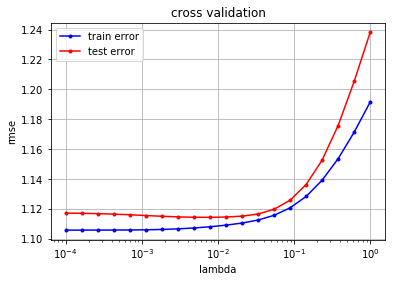

In [33]:
x1, m_X, s = standardize(x_clean.copy())
x1 = x1[0:68110]
y1 = y_clean[0:68110].copy()
print("Least-Square-GD")
#cross_validation_LS_GD_demo(x1,y1,5)
print("Least-Square-SGD")
#cross_validation_LS_SGD_demo(x1,y1,5)
print("Least-Square")
compute_least_squares(x1,y1)
print("Ridge Regression")
cross_validation_demo_RR(x1,y1,5)
print("Logistic Regression")
cross_validation_LR_demo(x1,y1,5)
print("Regularized Logistic Regression")
cross_validation_LRR_demo(x1,y1,5)

### Accuracy for standardized dataset 

In [ ]:
x2= x_nan.copy()
y2= y.copy()
print("Least-Square-GD")
#cross_validation_LS_GD_demo(x2,y2,5)
print("Least-Square-SDG")
#cross_validation_LS_SGD_demo(x2,y2,5)
print("Least-Square")
compute_least_squares(x2,y2)
#print("Ridge Regression")
#cross_validation_demo_RR(x2,y2,5)
print("Logistic Regression")
cross_validation_LR_demo(x2,y2,5)
print("Regularized Logistic Regression")
cross_validation_LRR_demo(x2,y2,5)

### Accuracy for standardized subgroups

In [ ]:
print("Logistic Regression")
cross_validation_LR_demo(x3,y3,2)

In [27]:
x3 = x_subgroups
y3 = y.copy()
print("Least-Square-GD")
cross_validation_LS_GD_demo(x3,y3,5)
print("Least-Square-SDG")
cross_validation_LS_SGD_demo(x3,y3,5)
print("Least-Square")
compute_least_squares(x3,y3)
#print("Ridge Regression")
#cross_validation_demo_RR(x3,y3,5)
print("Logistic Regression")
cross_validation_LR_demo(x3,y3,2)
print("Regularized Logistic Regression")
cross_validation_LRR_demo(x3,y3,5)

Least-Square-GD
   gamma=0.234, mse=0.694
   accuracy=0.740
Least-Square-SDG


KeyboardInterrupt: 

### Accuracy with removed features

In [ ]:
x4 =x_s.copy()
y4 =y_s.copy()
print("Least-Square-GD")
cross_validation_LS_GD_demo(x4,y4,4)
print("Least-Square-SDG")
cross_validation_LS_SGD_demo(x4,y4,4)
print("Least-Square")
compute_least_squares(x4,y4)
#print("Ridge Regression")
#cross_validation_demo_RR(x4,y4,4)
print("Logistic Regression")
cross_validation_LR_demo(x4,y4,4)
print("Regularized Logistic Regression")
cross_validation_LRR_demo(x4,y4,4)

## Generate predictions and Save output in CSV format for submission

In [ ]:
DATA_TEST_PATH = '../data/test.csv/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = './logisticRegression_x_te_s' # TODO: fill in desired name of output file for submission
tX_test = np.c_[np.ones((tX_test.shape[0], 1)), tX_test]
tX_test = selected_non_nan_columns(tX_test)
y_pred = predict_labels(optimal_weights_LR, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)